# Exploring the WCWH Ambassador Family Beacon IAQ Data
(See [GH repo](https://github.com/intelligent-environments-lab/utx000))

# Comparing Ambassador Family Data to UTx000 Data
A look ath the differences in measurements made between the two cohorts.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# Package Import

In [2]:
import sys
sys.path.append('../')

from src.visualization import visualize
from src.data import wcwh
from src.exploration import beacon_summary

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

from datetime import datetime, timedelta

from pymer4.models import Lmer

# Table of Contents
1. [Notes on Analysis and References](#refs)
2. [Data Notes and Import](#import)
3. [Operation and Available Data](#operation)
4. [Aggregated Summary](#aggregated)
5. [Participant Based](#pt-based)

---

<a id="refs"></a>

# Notes on Analysis and References
The analyses in this notebook are primarily surface-level, but are described briefly below.

## UTx000 Participants to Consider
We only want to consider participants that collected data in Austin, namely in Central Austin. This limits the beacon data to the following devices:

```python
beacon_ux_aus = [1, 5, 10, 11, 13, 22, 23, 25, 28, 29, 30, 34, 40, 48]
```

## WCWH Ambassador Families to Consider
The ambassador families represent those that signed on for a beta test of all our protocol including the BEVO Beacon. The following devices were included in the rollout:

```python
beacon_af = [1,16,30,36]
```

## References
Some of the references used for analysis as well as for programming.

### Programming
1. [Legend on Seaborn Plots](https://stackoverflow.com/questions/64014746/how-do-you-create-a-legend-for-kde-plot-in-seaborn)
2. [Remove Legend](https://stackoverflow.com/questions/5735208/remove-the-legend-on-a-matplotlib-figure)
1. [Running Linear Mixed Effects Models in Python](https://towardsdatascience.com/how-to-run-linear-mixed-effects-models-in-python-jupyter-notebooks-4f8079c4b589): For the LME analysis.

---

<a id="import"></a>

# Data Notes and Import
Some notes on the data we use and then importing the actual data to look at.

<div class="alert alert-block alert-info">
 
Testing the functionality of the beacon data import class for the WCWH pilot family era.
    
</div>

In [3]:
def resample_data(df,resample_rate=1):
    """Resamples data per participant"""
    df_resampled = pd.DataFrame()
    for bb in df["beacon"].unique():
        df_bb = df[df["beacon"] == bb]
        df_bb_resampled = df_bb.resample(f"{resample_rate}T").mean()
        df_bb_resampled["beacon"] = bb
        df_resampled = df_resampled.append(df_bb_resampled)
        
    return df_resampled

In [4]:
def get_data(study_suffix, beacon_list, params=["tvoc","co","co2","pm2p5_mass"], resample_rate=1, remove_outliers=False):
    """
    Gets beacon data from the provided study
    
    Parameters
    ----------
    study_suffix : str
    
    beacon_list : list of int
    
    params : list of str, default ["tvoc","co","co2","pm2p5_mass"]
    
    resample_rate : int, default 1
        resmapling time in minutes
    remove_outliers : boolean, default False
        whether to remove outliers outside zscore of 2.5
    """
    try:
        temp = pd.read_csv(f"../data/processed/beacon-{study_suffix}.csv",index_col=0,parse_dates=["timestamp"],infer_datetime_format=True)
    except FileNotFoundError:
        print("No beacon found from study", study_suffix)
        return
    
    temp_restricted = temp[temp["beacon"].isin(beacon_list)]
    temp_restricted_filtered = temp_restricted[params+["beacon"]]
    temp_restricted_filtered_resampled = resample_data(temp_restricted_filtered, resample_rate=resample_rate)
    if remove_outliers:
        for param in params:
            temp_restricted_filtered_resampled['z'] = abs(temp_restricted_filtered_resampled[param] - temp_restricted_filtered_resampled[param].mean()) / temp_restricted_filtered_resampled[param].std(ddof=0)
            temp_restricted_filtered_resampled.loc[temp_restricted_filtered_resampled['z'] > 2.5, param] = np.nan
            
        temp_restricted_filtered_resampled.drop(["z"],axis=1,inplace=True)
        
    temp_restricted_filtered.dropna(how="all",subset=params,inplace=True)
    
    return temp_restricted_filtered_resampled
    

## UTx000 Data

In [5]:
beacon_ux_aus = [1, 5, 10, 11, 13, 22, 23, 25, 28, 29, 30, 34, 40, 48]
data_ux = get_data("ux_s20", beacon_ux_aus, resample_rate=60, remove_outliers=True)

In [6]:
data_ux.head()

,tvoc,co,co2,pm2p5_mass,beacon
timestamp,,,,,
2020-06-08 13:00:00,69.624578,NaN,NaN,25.280929,1
2020-06-08 14:00:00,57.937945,NaN,NaN,28.375054,1
2020-06-08 15:00:00,94.477662,NaN,NaN,27.696586,1
2020-06-08 16:00:00,124.160613,NaN,NaN,26.217002,1
2020-06-08 17:00:00,55.539679,NaN,NaN,25.921108,1


In [7]:
print("Number of participants:",len(beacon_ux_aus))

Number of participants: 14


## Ambassador Family Data

In [8]:
beacon_af = [1,16,30,36]
data_af = get_data("wcwh_s21", beacon_af, resample_rate=60, remove_outliers=True)

In [9]:
data_af.head()

,tvoc,co,co2,pm2p5_mass,beacon
timestamp,,,,,
2022-01-01 00:00:00,18.324328,10.859942,1391.159192,20.439477,1
2022-01-01 01:00:00,205.609116,9.905834,1498.373232,22.147823,1
2022-01-01 02:00:00,71.329945,9.386053,1661.465081,17.802431,1
2022-01-01 03:00:00,8.859617,9.344003,1948.414239,14.846197,1
2022-01-01 04:00:00,7.406743,9.015256,1954.098824,13.029589,1


---

<a id="operation"></a>

# Visualizations
A look at the differences between measurements

## KDE

In [10]:
def plot_kde(df1, df2, param, study1="UTx000", study2="Ambassador Families"):
    """
    Plots the KDE for each parameter
    """
    _, ax = plt.subplots(figsize=(16,4))
    s1_kde = sns.kdeplot(param,cut=0,data=df1,ax=ax,
              linewidth=2,color="seagreen",label=study1)
    s2_kde = sns.kdeplot(param,cut=0,data=df2,ax=ax,
              linewidth=2,color="cornflowerblue",label=study2)
    
    # x-axis
    ax.set_xlabel(f"{visualize.get_label(param)} ({visualize.get_units(param)})",fontsize=16)
    # y-axis
    ax.set_ylabel("Density",fontsize=16)
    # remainder
    ax.tick_params(labelsize=14)
    plt.legend(frameon=False,fontsize=14)
    
    plt.show()
    plt.close()

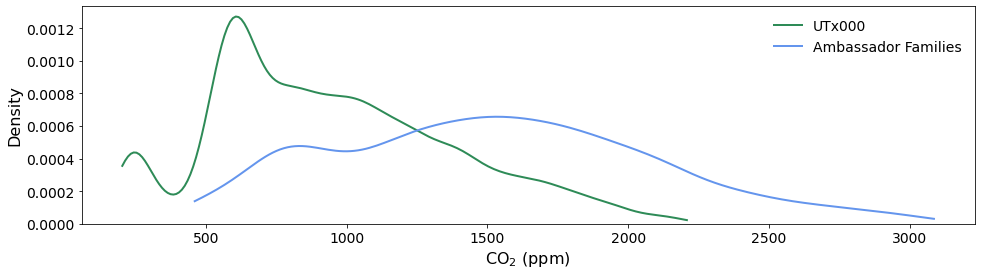

In [11]:
plot_kde(data_ux,data_af,"co2")

## Boxplot

In [12]:
def plot_boxplot_comparison(df1,df2,params=["tvoc","co","co2","pm2p5_mass"],study1="UTx000",study2="Ambassador\nFamilies",save=False,**kwargs):
    """
    Plots boxplots to compare distributions of values
    
    Parameters
    ----------
    
    Returns
    -------
    <void>
    """
        
    # getting df in order
    df1["study"] = study1
    df2["study"] = study2
    df = df1.append(df2)
    
    # plotting
    _, axes = plt.subplots(1,len(params),figsize=(14,5),gridspec_kw={"wspace":0.5})
    for param, ax in zip(params,axes):
        df["parameter"] = visualize.get_label(param)
        sns.boxplot(x="parameter",y=param,hue="study",data=df,ax=ax,
                   palette=["seagreen","cornflowerblue"],whis=1.5)
        #x-axis
        ax.set_xlabel("")
        # y-axis
        ax.set_ylim(bottom=0)
        ax.set_ylabel(visualize.get_units(param),fontsize=16)
        # remainder
        ax.tick_params(labelsize=14)
        if param == params[-1]:
            ax.legend(bbox_to_anchor=(-0.25,-0.08),frameon=False,fontsize=14,ncol=2)
        else:
            ax.get_legend().remove()
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
    
    if save:
        s1 = study1.replace('\n','_').lower()
        s2 = study2.replace('\n','_').lower()
        plt.savefig(f"../reports/figures/beacon_summary/boxplot_comparison-{s1}-{s2}.pdf",layout="tight")
    plt.show()
    plt.close()

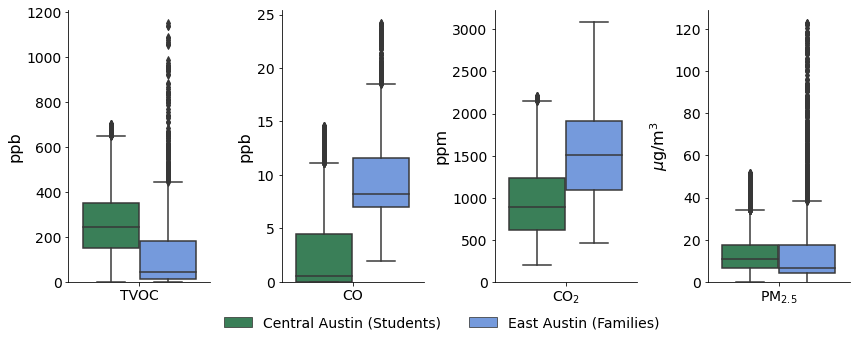

In [13]:
plot_boxplot_comparison(data_ux,data_af,study1="Central Austin (Students)", study2="East Austin (Families)",save=False)

## Violins

In [14]:
def plot_violin_comparison(df1,df2,params=["tvoc","co","co2","pm2p5_mass"],study1="UTx000",study2="Ambassador\nFamilies",save=False,**kwargs):
    """
    Plots violins to compare distributions of values
    
    Parameters
    ----------
    
    Returns
    -------
    <void>
    """
    
    # resampling
    if "resample" in kwargs.keys():
        df1 = resample_data(df1,kwargs['resample'])
        df2 = resample_data(df2,kwargs['resample'])
        
    # getting df in order
    df1["study"] = study1
    df2["study"] = study2
    df = df1.append(df2)
    
    # plotting
    _, axes = plt.subplots(1,len(params),figsize=(14,5),gridspec_kw={"wspace":0.5})
    for param, ax in zip(params,axes):
        df["parameter"] = visualize.get_label(param)
        sns.violinplot(x="parameter",y=param,hue="study",data=df,cut=0,split=True,ax=ax,
                   palette=["seagreen","cornflowerblue"],inner="quartile")
        #x-axis
        ax.set_xlabel("")
        # y-axis
        ax.set_ylim(bottom=0)
        ax.set_ylabel(visualize.get_units(param),fontsize=16)
        # remainder
        ax.tick_params(labelsize=14)
        if param == params[-1]:
            ax.legend(bbox_to_anchor=(-0.25,-0.08),frameon=False,fontsize=14,ncol=2)
        else:
            ax.get_legend().remove()
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
    
    if save:
        s1 = study1.replace('\n','_').replace(' ','_').lower()
        s2 = study2.replace('\n','_').replace(' ','_').lower()
        plt.savefig(f"../reports/figures/beacon_summary/violin_comparison-{s1}-{s2}.pdf",layout="tight")
    plt.show()
    plt.close()

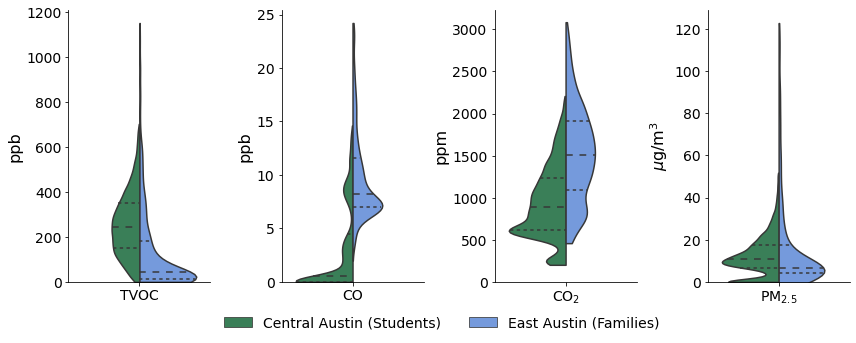

In [15]:
plot_violin_comparison(data_ux,data_af,study1="Central Austin (Students)", study2="East Austin (Families)", save=False)

<div class="alert alert-block alert-info">
 
IAQ seems to be worse in the homes of the ambassador families except when considering `tvoc` although there is a wider range and more extreme outliers.
    
</div>

---

<a id="aggregated"></a>

# Statistics
Summary stats and some more involved analysis

## Summary
Summary statistics from the two studies

In [16]:
def get_summary_stats(df,params=["tvoc","co","co2","pm2p5_mass"],resample=1):
    """Gets summary statistics for the given dataframe"""
    
    df = resample_data(df,resample_rate=resample)
    
    res = {"n":[],"min":[],"25":[],"median":[],"75":[],"max":[]}
    for param in params:
        for key, val in zip(res.keys(),[len(df[param].dropna()),np.nanmin(df[param]),np.nanpercentile(df[param],25),
                                        np.nanmedian(df[param]),np.nanpercentile(df[param],75),
                                        np.nanmax(df[param])]):
            res[key].append(val)
        
    return pd.DataFrame(res,index=params)

### UTx000

In [17]:
get_summary_stats(data_ux,resample=60)

,n,min,25,median,75,max
tvoc,16266,0.000000,149.172600,246.062059,349.980061,703.436190
co,16225,0.000000,0.000000,0.580360,4.452989,14.623800
co2,15927,202.742629,618.474295,889.280057,1232.561756,2208.409480
pm2p5_mass,17268,0.000000,6.788126,11.058977,17.644154,51.751534


### Ambassador Families

In [18]:
get_summary_stats(data_af,resample=60)

,n,min,25,median,75,max
tvoc,2124,0.000000,10.531583,43.565094,183.711776,1152.441687
co,2095,1.992005,6.985268,8.178781,11.588883,24.210876
co2,2179,460.068032,1097.534854,1510.040688,1910.834365,3085.989046
pm2p5_mass,2114,-0.550154,4.033529,6.763708,17.709463,122.738504


## Mood's Median Test
Like Welch's t-Test, but on the medians of the distributions rather than the means.

In [19]:
from scipy.stats import median_test

In [20]:
params=["tvoc","co","co2","pm2p5_mass"]
for param in params:
    stat, p, m, table = median_test(data_ux[param].values, data_af[param].values,nan_policy="omit")
    print(f"{param}: {p}")

tvoc: 9.499493970918892e-194
co: 0.0
co2: 1.6175505146876563e-204
pm2p5_mass: 1.8799873891128544e-44


<div class="alert alert-block alert-success">
 
The medians are _significantly_ different between distributions.
    
</div>

## Welch's t-Test

In [21]:
from scipy.stats import ttest_ind

In [22]:
params=["tvoc","co","co2","pm2p5_mass"]
for param in params:
    t, p = ttest_ind(data_ux[param].values, data_af[param].values,equal_var=False,nan_policy="omit")
    print(f"{param}: {p}")

tvoc: 1.5706456469130414e-162
co: 0.0
co2: 0.0
pm2p5_mass: 2.2332582031131395e-18


<div class="alert alert-block alert-success">
 
Even more so, the means of the distributions are _significantly_ different between distributions.
    
</div>

## Mixed ANOVA/Split-Plot ANOVA
Learn more [here](https://statistics.laerd.com/spss-tutorials/mixed-anova-using-spss-statistics.php)

In [23]:
def combine_and_resample(df1, df2, study1="UTx000", study2="Ambassador Families", resample_rate=1, remove_na=True):
    """
    Combines, adds labels, resamples, and [maybe] drops NaN
    
    Parameters
    ----------
    
    Returns
    -------
    df : DataFrame
        cleaned dataframe
    """
    # Resampling
    # ----------
    ## Have to separate by beacon so that I don't resample the beacon number...
    ## Study 1
    df1_resampled = pd.DataFrame()
    for bb in df1["beacon"].unique():
        df_bb = df1[df1["beacon"] == bb]
        df_bb_resampled = df_bb.resample(f"{resample_rate}T").mean()
        df_bb_resampled["beacon"] = bb
        df1_resampled = df1_resampled.append(df_bb_resampled)
    ## Study 2
    df2_resampled = pd.DataFrame()
    for bb in df2["beacon"].unique():
        df_bb = df2[df2["beacon"] == bb]
        df_bb_resampled = df_bb.resample(f"{resample_rate}T").mean()
        df_bb_resampled["beacon"] = bb
        df2_resampled = df2_resampled.append(df_bb_resampled)
        
    # Labeling
    df1_resampled["study"] = study1
    df2_resampled["study"] = study2
    
    # Combining
    df = df1_resampled.append(df2_resampled)
    
    # Removing NaN
    if remove_na:
        df.dropna(how="any",inplace=True)
    
    return df

In [24]:
data = combine_and_resample(data_ux, data_af, resample_rate=60)

In [25]:
data.head()

,tvoc,co,co2,pm2p5_mass,beacon,study
timestamp,,,,,,
2020-06-09 11:00:00,0.000000,14.306310,615.663016,32.940397,1,UTx000
2020-06-09 12:00:00,0.135472,13.013227,636.839059,31.332884,1,UTx000
2020-06-09 13:00:00,3.064409,11.913453,633.773553,31.026540,1,UTx000
2020-06-09 14:00:00,9.153643,11.171782,659.136100,45.666537,1,UTx000
2020-06-09 15:00:00,14.175602,10.744059,667.008284,43.505947,1,UTx000


---

<a id="pt-based"></a>

# Participant-Based Summary

---